<a href="https://colab.research.google.com/github/RaghavPeri/ai-mvp-portfolio/blob/main/audience-targeting-engine/Audience_Targeting_Engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🎯 Audience Targeting Engine – Overview
This notebook demonstrates an end-to-end Customer Segmentation Workflow using RFM-based behavioral scoring, unsupervised ML (KMeans), and Google Sheets integration.

It includes two primary use cases:

**Customer Segmentation** — Cluster historical customers into behavioral personas using Recency, Frequency, and MonetaryValue metrics

**New User Prediction** — Accept live RFM inputs via a Google Sheet and instantly assign campaign-ready customer segments with action plans

## 📊 MVP Core: RFM-Based Customer Segmentation – KMeans Clustering & Cohort Strategy

This section computes **Recency, Frequency, and Monetary Value (RFM)** metrics from retail transaction data and clusters customers using `KMeans` to enable **cohort-based targeting**.

### 🔍 What It Does:
- Loads and cleans transactional data from the `Training_Data` Google Sheet
- Calculates core RFM features:
  - **Recency**: Days since last purchase
  - **Frequency**: Number of unique purchase transactions
  - **MonetaryValue**: Total customer spend
- Scales the RFM features using `StandardScaler`
- Applies **KMeans clustering** to group customers into segments
- Validates the optimal number of clusters using the **Silhouette Score**
- Maps each segment to a predefined **ActionPlan** (e.g., re-engagement, VIP upsell)
- Writes the fully segmented output to the `Segmented_Customers` sheet


🔧 Step 1: Installing required libraries...
✅ Libraries successfully installed and imported.

🔐 Step 2: Authenticating and connecting to Google Sheets...
✅ Google Sheet connection established.

📥 Step 3: Reading training data from 'Training_Data' sheet...
✅ Training data read successfully. Total raw rows: 541909

🧼 Step 4: Cleaning data and computing RFM values...
✅ Step 4 complete: RFM table with 4339 customers written to 'RFM' sheet.

📊 Step 5: Reading 'RFM' data and performing KMeans clustering...
✅ KMeans clustering complete. Total segments identified: 4

✅ Step 6: Compute Silhouette Score.

📈 Silhouette Score: 0.62
ℹ️ This score measures how well-separated your clusters are. Higher values (closer to 1.0) indicate better-defined clusters.


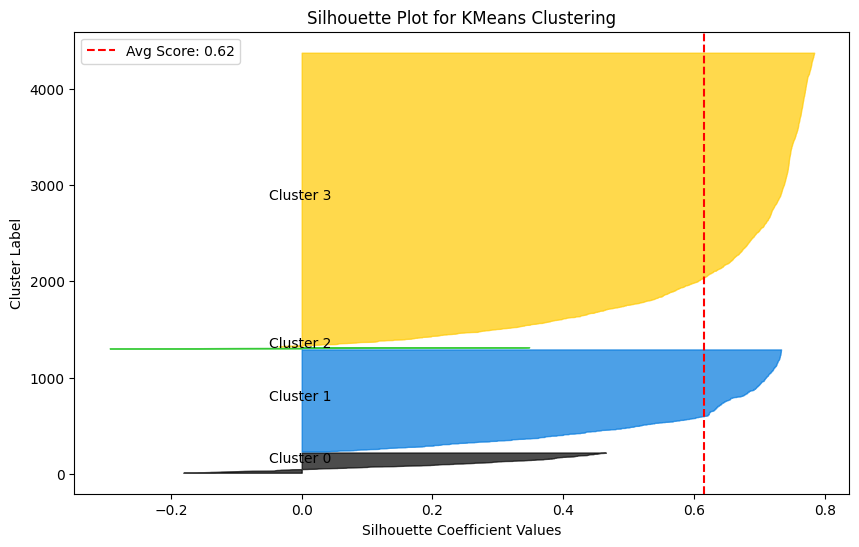


🎯 Step 7: Assigning action plans to each segment...

📌 Cluster Summary (Avg RFM by Segment):
   Cluster  Recency  Frequency  MonetaryValue
0        0     15.7       22.0        12453.2
1        1    248.6        1.6          478.1
2        2      7.4       82.7       127338.3
3        3     43.9        3.7         1349.7

📦 Customers per Segment:
🧩 Segment 0 → 🔥 High value – Loyalty rewards: 211 customers
🧩 Segment 1 → 🧊 Low frequency – Re-engagement: 1062 customers
🧩 Segment 2 → 💰 VIP – Upsell & exclusives: 13 customers
🧩 Segment 3 → 🛒 Bargain hunters – Promo offers: 3053 customers

✅ Step 8 complete: Segmented customer data written to 'Segmented_Customers' sheet.

🚀 Ready to accept new customer data via the 'New User' sheet and classify it in real-time.


In [34]:
# STEP 1: Install and Import Required Libraries
print("🔧 Step 1: Installing required libraries...")
!pip install --quiet gspread pandas scikit-learn pytz

import pandas as pd
import gspread
from google.colab import auth
from google.auth import default
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

print("✅ Libraries successfully installed and imported.")

# STEP 2: Authenticate and Connect to Google Sheet
print("\n🔐 Step 2: Authenticating and connecting to Google Sheets...")

auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# Replace with your actual sheet ID
sheet_id = '1ewwoAaG5gWdRgFBYOmDND6oeMJjrCmh93NI6sJqEFRI'
print("✅ Google Sheet connection established.")

# STEP 3: Read Training Data from 'Training_Data' Sheet
print("\n📥 Step 3: Reading training data from 'Training_Data' sheet...")
ws = gc.open_by_key(sheet_id).worksheet('Training_Data')
data = ws.get_all_records()
df = pd.DataFrame(data)
print(f"✅ Training data read successfully. Total raw rows: {len(df)}")

# STEP 4: Clean Data and Generate RFM Table
print("\n🧼 Step 4: Cleaning data and computing RFM values...")

# ✅ Parse 'InvoiceDate' column and handle any format issues
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%m/%d/%y %H:%M', errors='coerce')

# ✅ Drop rows with missing CustomerID or InvoiceDate
df = df.dropna(subset=['CustomerID', 'InvoiceDate'])

# ✅ Keep only valid (positive quantity) transactions
df = df[df['Quantity'] > 0]

# ✅ Create TotalPrice field for each transaction
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# ✅ Clean and standardize CustomerID
df['CustomerID'] = df['CustomerID'].astype(str).str.strip()
df = df[df['CustomerID'] != ""]  # remove truly blank IDs

# ✅ Set snapshot date to 1 day after last InvoiceDate (as per RFM convention)
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# ✅ Group by CustomerID to compute RFM metrics
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,   # Recency
    'InvoiceNo': 'nunique',                                    # Frequency
    'TotalPrice': 'sum'                                        # Monetary Value
}).reset_index()

# ✅ Rename columns for clarity
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'MonetaryValue']

# ✅ Final cleaning and formatting
rfm = rfm[rfm['CustomerID'].str.strip() != ""]
rfm['MonetaryValue'] = rfm['MonetaryValue'].round(2)

# ✅ Write to 'RFM' sheet in Google Sheets
rfm_sheet = gc.open_by_key(sheet_id).worksheet('RFM')
rfm_sheet.clear()
rfm_data = [rfm.columns.tolist()] + rfm.astype(str).values.tolist()
rfm_sheet.update(rfm_data)

print(f"✅ Step 4 complete: RFM table with {rfm.shape[0]} customers written to 'RFM' sheet.")

# STEP 5: Perform KMeans Clustering on RFM Data
print("\n📊 Step 5: Reading 'RFM' data and performing KMeans clustering...")

rfm_ws = gc.open_by_key(sheet_id).worksheet('RFM')
rfm_data = rfm_ws.get_all_records()
rfm_df = pd.DataFrame(rfm_data)

rfm_df[['Recency', 'Frequency', 'MonetaryValue']] = rfm_df[['Recency', 'Frequency', 'MonetaryValue']].astype(float)
rfm_df['CustomerID'] = rfm_df['CustomerID'].astype(str)

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df[['Recency', 'Frequency', 'MonetaryValue']])

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_scaled)

print(f"✅ KMeans clustering complete. Total segments identified: {rfm_df['Cluster'].nunique()}")

# STEP 6: Compute Silhouette Score
score = silhouette_score(rfm_scaled, rfm_df['Cluster'])
print("\n✅ Step 6: Compute Silhouette Score.")
print(f"\n📈 Silhouette Score: {score:.2f}")
print("ℹ️ This score measures how well-separated your clusters are. Higher values (closer to 1.0) indicate better-defined clusters.")

import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples
import numpy as np

# Compute silhouette values for each point
sample_silhouette_values = silhouette_samples(rfm_scaled, rfm_df['Cluster'])

fig, ax = plt.subplots(figsize=(10, 6))
y_lower = 10
for i in range(kmeans.n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[rfm_df['Cluster'] == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / kmeans.n_clusters)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                     facecolor=color, edgecolor=color, alpha=0.7)

    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, f"Cluster {i}")
    y_lower = y_upper + 10

ax.axvline(x=score, color="red", linestyle="--", label=f"Avg Score: {score:.2f}")
ax.set_xlabel("Silhouette Coefficient Values")
ax.set_ylabel("Cluster Label")
ax.set_title("Silhouette Plot for KMeans Clustering")
ax.legend()
plt.show()



# STEP 7: Assign Action Plans to Segments
print("\n🎯 Step 7: Assigning action plans to each segment...")

cluster_summary = rfm_df.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': 'mean'
}).round(1).reset_index()

action_map = {
    0: "🔥 High value – Loyalty rewards",
    1: "🧊 Low frequency – Re-engagement",
    2: "💰 VIP – Upsell & exclusives",
    3: "🛒 Bargain hunters – Promo offers"
}

rfm_df['ActionPlan'] = rfm_df['Cluster'].map(action_map)

print("\n📌 Cluster Summary (Avg RFM by Segment):")
print(cluster_summary)

print("\n📦 Customers per Segment:")
segment_counts = rfm_df.groupby('Cluster').agg({
    'CustomerID': 'count',
    'ActionPlan': 'first'
}).reset_index().sort_values('Cluster')

for _, row in segment_counts.iterrows():
    print(f"🧩 Segment {row['Cluster']} → {row['ActionPlan']}: {row['CustomerID']} customers")


# STEP 8: Write Segmented Output to Sheet
seg_ws = gc.open_by_key(sheet_id).worksheet('Segmented_Customers')
seg_ws.clear()
seg_data = [rfm_df.columns.tolist()] + rfm_df.astype(str).values.tolist()
seg_ws.update(seg_data)

print("\n✅ Step 8 complete: Segmented customer data written to 'Segmented_Customers' sheet.")
print("\n🚀 Ready to accept new customer data via the 'New User' sheet and classify it in real-time.")


## 🔄 MVP Extension: New User Prediction – Live Customer Segmentation and Targeting

This section enables **real-time scoring** of new customers by reading RFM values from the `New User` Google Sheet and predicting their segment using the trained KMeans model.

### 🔍 What It Does:
- Reads newly entered RFM records from the `New User` sheet
- Detects and processes only **unclassified rows** to prevent overwrites
- Applies the trained `StandardScaler` and `KMeans` model to assign customer segments
- Maps predicted segments to business actions (e.g., 🛒 Promo Offers, 💰 VIP Upsell)
- Timestamps each prediction using EST in the `PredictedAt` column
- Appends all predictions to the `Prediction_Log` sheet for traceability and audits
- Built to be **fully re-runnable** — safe for daily or scheduled execution


In [33]:
# ✅ Step 9: Predict clusters ONLY for new rows, update sheet + Prediction_Log

!pip install --quiet pytz
from datetime import datetime
import pytz

# ✅ Set Eastern Timezone
est = pytz.timezone('US/Eastern')

# ✅ Read 'New User' sheet
new_ws = gc.open_by_key(sheet_id).worksheet('New User')
raw_data = new_ws.get_all_records()
df = pd.DataFrame(raw_data)

# 🧼 Check if empty
if df.empty or df.shape[0] == 0:
    print("⚠️ No data in 'New User' sheet.")
else:
    try:
        # ✅ Ensure expected columns exist
        for col in ['Cluster', 'ActionPlan', 'PredictedAt']:
            if col not in df.columns:
                df[col] = ""

        # ✅ Identify only unclassified rows (fix: check for empty or null)
        mask = (df['Cluster'].astype(str).str.strip() == "") | (df['ActionPlan'].astype(str).str.strip() == "")
        new_rows = df[mask].copy()

        if new_rows.empty:
            print("✅ All rows already classified — no new rows to update.")
        else:
            # ✅ Scale and predict
            new_rfm = new_rows[['Recency', 'Frequency', 'MonetaryValue']].astype(float)
            new_scaled = scaler.transform(new_rfm)

            clusters = kmeans.predict(new_scaled)
            actions = [action_map.get(c, "No action defined") for c in clusters]
            timestamps = [datetime.now(est).strftime("%Y-%m-%d %I:%M %p %Z")] * len(new_rows)

            # ✅ Add results back to *new_rows* directly
            new_rows['Cluster'] = clusters
            new_rows['ActionPlan'] = actions
            new_rows['PredictedAt'] = timestamps

            # ✅ Update master df
            df.update(new_rows)

            # ✅ Write to 'New User' sheet
            output_data = [df.columns.tolist()] + df.astype(str).values.tolist()
            new_ws.clear()
            new_ws.update(output_data)
            print(f"✅ {len(new_rows)} new user(s) predicted and updated in 'New User' sheet.")

            # ✅ Optional preview
            print("\n🧾 New User Predictions Preview:")
            print(new_rows[['Recency', 'Frequency', 'MonetaryValue', 'Cluster', 'ActionPlan', 'PredictedAt']].head())

            # ✅ Log to Prediction_Log
            try:
                log_ws = gc.open_by_key(sheet_id).worksheet('Prediction_Log')
                log_data = new_rows.astype(str).values.tolist()
                log_ws.append_rows(log_data)
                print(f"\n🗂️ Appended {len(log_data)} new row(s) to 'Prediction_Log' for traceability.")
            except Exception as e:
                print(f"⚠️ Couldn't write to Prediction_Log: {e}")

    except Exception as e:
        print(f"❌ Error during prediction: {e}")


✅ 1 new user(s) predicted and updated in 'New User' sheet.

🧾 New User Predictions Preview:
   Recency  Frequency  MonetaryValue  Cluster                      ActionPlan  \
0      100        100           4000        0  🔥 High value – Loyalty rewards   

               PredictedAt  
0  2025-06-05 11:22 PM EDT  

🗂️ Appended 1 new row(s) to 'Prediction_Log' for traceability.


## ✅ MVP Summary: Audience Targeting Engine

This notebook powers **real-time customer segmentation** using RFM (Recency, Frequency, Monetary) data and a trained KMeans model. It predicts customer clusters, maps them to personalized action plans, and maintains a timestamped prediction log for marketing traceability.

### 🔍 What It Demonstrates:
- Reads live customer RFM data from Google Sheets
- Applies `StandardScaler` and `KMeans` to classify users into segments
- Associates each cluster with business-ready action plans (e.g., 🎯 Retargeting, 🛍️ Promo, 💰 VIP Upsell)
- Adds EST-based timestamps for prediction events
- Logs all classified entries into a `Prediction_Log` sheet to preserve history and support audits

### 🧰 Tech Stack:
- Google Colab
- `scikit-learn`, `pandas`, `pytz`, `gspread`, `oauth2client`
- Google Sheets API for dynamic integration and automation

### 🗂️ Prediction_Log Sheet Includes:
1. RFM values: `Recency`, `Frequency`, `MonetaryValue`
2. Model output: `Cluster`
3. Prescribed `ActionPlan` based on cluster logic
4. `PredictedAt`: Timestamp in EST for traceability
5. Rerunnable workflow that avoids reprocessing already classified rows

### 🎯 Product Thinking:
- Frames segmentation as an automated pipeline that supports **daily targeting ops**
- Enables always-on personalization while ensuring **auditability**
- Ready for integration with CRM campaigns, email marketing, and retargeting tools
- Future-ready design to plug in other models (e.g., churn risk, lifetime value)
